# Plot matched MA and LN adaptive responses to block vs natural song segments

Our prediction is: for the class of LN models we consider (double-exponential filters within a range of timescales + rectifying nonlinearity), the equivalent MA models can show a stronger response to natural song, but LN models cannot.

In [1]:
%matplotlib inline
from itertools import product as cprod
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy import signal

from aux import zscore, get_seg
from disp import set_plot, plot_b, get_line

from record_0_main import smlt_ma, smlt_lnma

cc = np.concatenate

FPS = 30.03
DT = 1/FPS

In [2]:
# song snippets
def make_sng(t_max, s=None, p=None):
    if s is None:
        s = []
    if p is None:
        p = []
        
    t = np.arange(0, t_max, DT)
    sng = np.zeros(len(t))
    
    for start, end in s:
        sng[(start <= t) & (t < end)] = 1
        
    for start, end in p:
        sng[(start <= t) & (t < end)] = 2
    
    return sng.astype(int)

# Natural song snippets

In [3]:
STRAINS = ['NM91', 'ZH23']
FSTRAIN = 'data/simple/strains.csv'

MSTRAINS = [(pd.read_csv(FSTRAIN)['STRAIN'] == strain) for strain in STRAINS]
MSTRAIN = np.any(MSTRAINS, axis=0)
ISTRAIN = MSTRAIN.nonzero()[0]

NTR = MSTRAIN.sum()

In [4]:
# load natural songs
df_song = pd.read_csv('data/simple/c_song_f_behav.csv')[['ID', 'T', 'Q', 'S', 'P' ,'F']]
sngs_full = []
for itr in ISTRAIN:
    df_tr = df_song[df_song['ID'] == itr]
    sng_full = np.zeros(len(df_tr), dtype=int)
    sng_full[df_tr['S'] == 1] = 1
    sng_full[(df_tr['P'] == 1) | (df_tr['F'] == 1)] = 2
    sngs_full.append(sng_full)

In [5]:
from aux import get_seg
# get snippets
nt = int(round(60*FPS))
t = np.arange(nt)*DT

min_gap = int(round(5*FPS))
min_frac_sing = 0

sngs_all = []

for ctr, sng_full in enumerate(sngs_full):
    segs, bds = get_seg(sng_full > 0, min_gap=min_gap)
    segs = [sng_full[lb:ub] for lb, ub in bds]
    # keep fixed-length portions only of sufficiently long segments
    segs = [seg[:nt] for seg in segs if (len(seg) >= nt) and (np.mean(seg > 0) > min_frac_sing)]
    sngs_all.extend(segs)
    
sngs_all = np.array(sngs_all)
nsng = len(sngs_all)

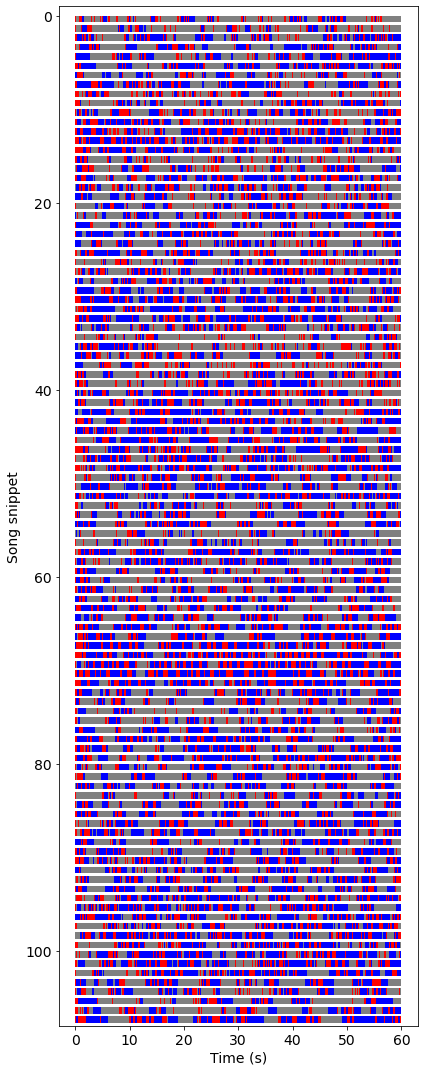

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(6, 15), tight_layout=True)
for csng, sng in enumerate(sngs_all):
    plot_b(ax, t, sng, [0, t.max(), csng, csng+.7], c=['gray', 'b', 'r'])
    
set_plot(ax, y_lim=(nsng, -1), x_label='Time (s)', y_label='Song snippet', font_size=14)

In [7]:
# neural params
params = {
    'TAU_R': np.array([30, 60, 60, 60, 2]),
    'TAU_A': np.array([2, 1, 1, 1, 2]),
    'X_P': np.array([.5, .5, 0, 1, .5]),
    'X_S': np.array([.5, .5, 1, 0, .5]),
}

nnrn = len(params['TAU_R'])

In [8]:
rs_ma_all = []
rs_lnma_all = []

for sng in sngs_all:

    i_s = (sng == 1).astype(float)
    i_p = (sng == 2).astype(float)

    rs_ma = smlt_ma(i_s, i_p, params, DT)
    rs_ma_all.append(rs_ma)
    
    rs_lnma = smlt_lnma(i_s, i_p, params, DT)
    rs_lnma_all.append(rs_lnma)

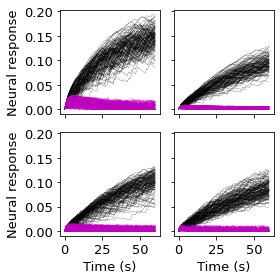

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(4, 4), tight_layout=True, sharex=True, sharey=True)
for cnrn, ax in enumerate(axs.flat):
    
    for rs_ma in rs_ma_all:
        ax.plot(t, rs_ma[:, cnrn], c='k', lw=.2)
        
    for rs_lnma in rs_lnma_all:
        ax.plot(t, rs_lnma[:, cnrn], c='m', lw=.2)
    
    if cnrn in [0, 2]:
        set_plot(ax, y_label='Neural response')
            
    if cnrn >= 2:
        set_plot(ax, x_label='Time (s)')
        
    set_plot(ax, font_size=13)
    
fig.savefig('ms/fig_4b.svg')

In [10]:
from scipy import stats

# compute accumulation slope for each MA neuron and song segment
sng_densities = []
sng_tr_rates = []

acum_slps_all = []

for csng, sng in enumerate(sngs_all):
    
    sng_densities.append(np.mean(sng > 0))
    sng_tr_rates.append(np.sum(np.abs(np.diff(sng)) > 0)/t[-1])
    
for cnrn in range(nnrn):
    acum_slps = []
    
    for csng, rs_ma in enumerate(rs_ma_all):
    
        acum_slps.append(stats.linregress(t, rs_ma[:, cnrn])[0])
        
    acum_slps_all.append(acum_slps)

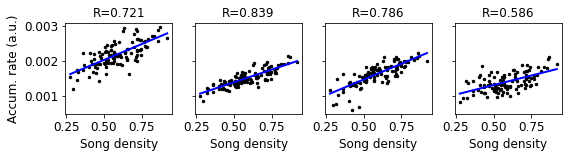

In [11]:
fig, axs = plt.subplots(1, 4, figsize=(8, 2.3), sharey=True, tight_layout=True)

for cnrn, (ax, acum_slps) in enumerate(zip(axs, acum_slps_all)):
    ax.scatter(sng_densities, acum_slps, c='k', s=6)
    
    x_ln, y_ln, (slp, icpt, r, p, stderr) = get_line(sng_densities, acum_slps)
    
    ax.plot(x_ln, y_ln, c='b', lw=2)
    
    if cnrn == 0:
        ax.set_ylabel('Accum. rate (a.u.)')
    set_plot(ax, x_label='Song density', title=f'R={r:.3f}', font_size=12)
    
fig.savefig('ms/fig_4c.svg')

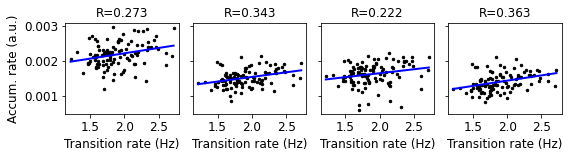

In [12]:
fig, axs = plt.subplots(1, 4, figsize=(8, 2.3), sharey=True, tight_layout=True)

for cnrn, (ax, acum_slps) in enumerate(zip(axs, acum_slps_all)):
    ax.scatter(sng_tr_rates, acum_slps, c='k', s=6)
    
    x_ln, y_ln, (slp, icpt, r, p, stderr) = get_line(sng_tr_rates, acum_slps)
    
    ax.plot(x_ln, y_ln, c='b', lw=2)
    
    if cnrn == 0:
        ax.set_ylabel('Accum. rate (a.u.)')
    set_plot(ax, x_label='Transition rate (Hz)', title=f'R={r:.3f}', font_size=12)
    
fig.savefig('ms/fig_4d.svg')